In [42]:
import pandas as pd
from sklearn.metrics.pairwise import haversine_distances
from math import radians
import sqlite3
import hvplot.pandas
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [43]:
connection = sqlite3.connect('proj4_grp2.sqlite')
data = pd.read_sql_query("SELECT * FROM realestate_info where state = 'AZ'", connection)
data.head()

,property_id,address,street_name,city,state,latitude,longitude,postcode,price,bedroom_number,bathroom_number,price_per_unit,living_space,land_space,property_type
0,8352055,"854 Citrus St, Bullhead City, AZ 86442",Citrus St,Bullhead City,AZ,35.114260,-114.618385,86442,54900.0,2.0,1.0,79.0,688.0,5000.0,MANUFACTURED
1,104049502,"411 Riverfront Dr LOT 5, Bullhead City, AZ 86442",Riverfront Dr LOT 5,Bullhead City,AZ,35.113700,-114.634460,86442,2200000.0,6.0,8.0,425.0,5173.0,6534.0,SINGLE_FAMILY
2,64954116,"1825 E Shore Villas Dr UNIT 33, Bullhead City,...",E Shore Villas Dr UNIT 33,Bullhead City,AZ,35.122700,-114.589750,86442,379900.0,3.0,3.0,230.0,1649.0,3640.0,SINGLE_FAMILY
3,71677227,"790 Stahlman Dr, Bullhead City, AZ 86442",Stahlman Dr,Bullhead City,AZ,35.118100,-114.620620,86442,549900.0,3.0,4.0,169.0,3250.0,10225.0,SINGLE_FAMILY
4,8351548,"905 Citrus St, Bullhead City, AZ 86442",Citrus St,Bullhead City,AZ,35.114693,-114.616250,86442,169900.0,3.0,2.0,146.0,1157.0,5000.0,MANUFACTURED


In [44]:
def get_similar_nearby_properties(ref_latitude, ref_longitude, ref_bedroom_number, 
                                  ref_bathroom_number, ref_price, data, max_distance_km=10,
                                max_bedroom_number_diff=1, max_bathroom_number_diff=1, max_price_diff=50000):
    # Convert latitude and longitude from degrees to radians
    data['lat_rad'] = data['latitude'].apply(lambda x: radians(x))
    data['lon_rad'] = data['longitude'].apply(lambda x: radians(x))

    # Reference point in radians
    ref_point = [radians(ref_latitude), radians(ref_longitude)]

    # Haversine formula to calculate distances
    data['distance'] = haversine_distances(data[['lat_rad', 'lon_rad']].values, [ref_point]).reshape(-1) * 6371.0

    # Filter properties within the specified distance
    nearby_properties = data[data['distance'] <= max_distance_km]

    # Filter properties with similar number of bedrooms and price
    similar_properties = nearby_properties[
        (abs(nearby_properties['bedroom_number'] - ref_bedroom_number) <= max_bedroom_number_diff) &
        (abs(nearby_properties['bathroom_number'] - ref_bathroom_number) <= max_bathroom_number_diff) &
        (abs(nearby_properties['price'] - ref_price) <= max_price_diff)
    ]

    # Sort by distance
    similar_properties = similar_properties.sort_values(by='distance')

    return similar_properties

reference_latitude = 35.113700
reference_longitude = -114.634460
reference_bedrooms = 6  
reference_bathrooms= 8
reference_price = 2200000

similar_nearby_properties = get_similar_nearby_properties(
    reference_latitude, reference_longitude, reference_bedrooms,reference_bathrooms, reference_price,
    data, max_distance_km=10, max_bedroom_number_diff=1,max_bathroom_number_diff=1, max_price_diff=50000, 
    
)

print("Similar Nearby Properties:")
print(similar_nearby_properties[['property_id', 'latitude', 'longitude', 'distance', 'bedroom_number','bathroom_number','living_space','price']])


Similar Nearby Properties:
  property_id  latitude  longitude  distance  bedroom_number  bathroom_number  \
1   104049502   35.1137 -114.63446       0.0             6.0              8.0   

   living_space      price  
1        5173.0  2200000.0  


In [45]:
numeric_dataset=data[['latitude','longitude','bedroom_number','bathroom_number','price']]
numeric_dataset.head()

,latitude,longitude,bedroom_number,bathroom_number,price
0,35.114260,-114.618385,2.0,1.0,54900.0
1,35.113700,-114.634460,6.0,8.0,2200000.0
2,35.122700,-114.589750,3.0,3.0,379900.0
3,35.118100,-114.620620,3.0,4.0,549900.0
4,35.114693,-114.616250,3.0,2.0,169900.0


In [46]:
# Create a a list to store inertia values and the values of k
inertia = []
k = list(range(1, 11))

In [47]:
for i in k:
    k_model = KMeans(n_clusters=i, random_state=1)
    k_model.fit(numeric_dataset)
    inertia.append(k_model.inertia_)

/Users/sophieyoon/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/sophieyoon/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/sophieyoon/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/sophieyoon/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [48]:
elbow_data = {"k": k, "inertia": inertia}
df_elbow = pd.DataFrame(elbow_data)

# Review the DataFrame
df_elbow.head()

,k,inertia
0,1,3.235664e+15
1,2,1.476663e+15
2,3,8.110219e+14
3,4,4.956079e+14
4,5,3.601716e+14


In [49]:
df_elbow.hvplot.line(
    x="k", 
    y="inertia", 
    title="Elbow Curve", 
    xticks=k
)

:Curve   [k]   (inertia)

/Users/sophieyoon/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/kv/1r00h_0j5jlcj8vsjgqkklx40000gn/T/ipykernel_29511/4253785390.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_dataset['Cluster'] = y


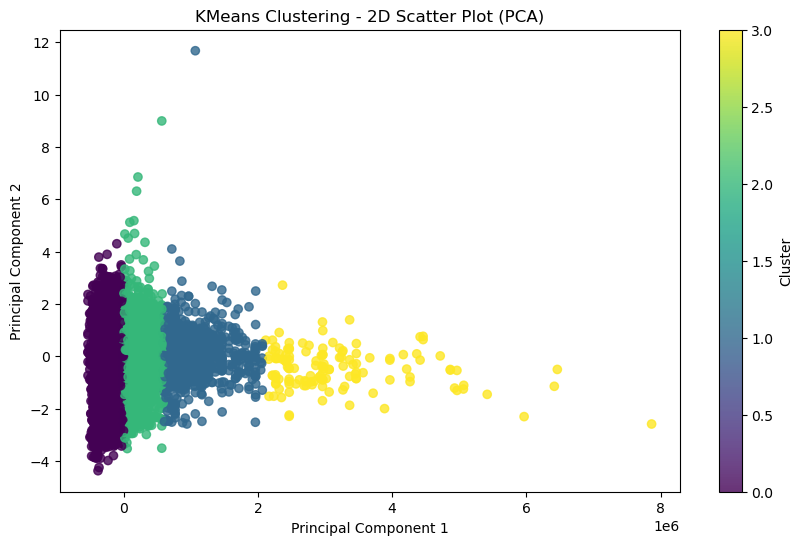

In [50]:
# Features for clustering
features_for_clustering = numeric_dataset[['latitude', 'longitude', 'bedroom_number', 'bathroom_number', 'price']]

# Apply KMeans clustering
kmeans = KMeans(n_clusters=4, random_state=1)
y = kmeans.fit_predict(features_for_clustering)
numeric_dataset['Cluster'] = y

# Apply PCA for dimensionality reduction to 2D
pca = PCA(n_components=2)
pca_result = pca.fit_transform(features_for_clustering)

# Create a 2D scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=numeric_dataset['Cluster'], cmap='viridis', alpha=0.8)
plt.title('KMeans Clustering - 2D Scatter Plot (PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.show()


/Users/sophieyoon/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/kv/1r00h_0j5jlcj8vsjgqkklx40000gn/T/ipykernel_29511/3361887543.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_dataset['Cluster'] = y


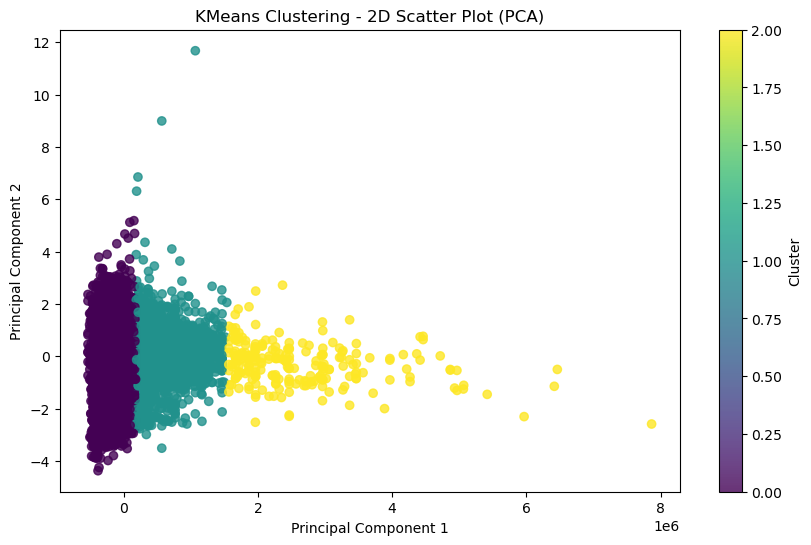

In [51]:
# Features for clustering
features_for_clustering = numeric_dataset[['latitude', 'longitude', 'bedroom_number', 'bathroom_number', 'price']]

# Apply KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=1)
y = kmeans.fit_predict(features_for_clustering)
numeric_dataset['Cluster'] = y

# Apply PCA for dimensionality reduction to 2D
pca = PCA(n_components=2)
pca_result = pca.fit_transform(features_for_clustering)

# Create a 2D scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=numeric_dataset['Cluster'], cmap='viridis', alpha=0.8)
plt.title('KMeans Clustering - 2D Scatter Plot (PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.show()

In [54]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score

# Calculate Silhouette Score
silhouette_avg = silhouette_score(features_for_clustering, numeric_dataset['Cluster'])
print(f"Silhouette Score: {silhouette_avg}")


Silhouette Score: 0.6647729692800081
